In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import urllib3
import requests
from bs4 import BeautifulSoup
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [2]:
# scrape html data from appropriate website
page_link = 'https://www.yelp.com/biz/kagura-torrance'

start = 0
num_pages = 19
end = 20 * num_pages

user_name = []
user_city = []
date = []
ratings = []
reviews = []

while (start < end):
    url = page_link + '?start=' + str(start)
    start += 20
    #print(url)
    
    page_response = requests.get(url)
    soup = BeautifulSoup(page_response.content, 'html.parser')
    
    for userInfo in soup.findAll('ul', {"class":"user-passport-info"}):
        user_name.append(userInfo.find('a').text)
        user_city.append(userInfo.find('b').text)
    
    for datePosted in soup.findAll('div', {"class": "biz-rating biz-rating-large biz-rating-large--wrap clearfix"}):
        date.append(datePosted.find('span', recursive=False).text)
    
    for reviewBody in soup.findAll('div', {"class":"review-content"}):
        ratings.append(reviewBody.div.div.div.get('title'))
        reviews.append(reviewBody.find('p').text)
        
#print(user_name)
#print(user_city)
#print(date)
#print(ratings)
#print(reviews)

### Data Preparation

In [3]:
# create dataframe
df = pd.DataFrame()
df['name'] = user_name
df['city'] = user_city
df['ratings'] = ratings
df['reviews'] = reviews
df.head()
#len(df)

,name,city,ratings,reviews
0,Lucas L.,"Torrance, CA",5.0 star rating,My fav restaurant in torrance The donkatsu is ...
1,Darian L.,"Torrance, CA",5.0 star rating,"If you're looking to get your katsu fix, this ..."
2,Becky K.,"El Segundo, CA",5.0 star rating,"In all honesty, Kagura is the king of all rest..."
3,Rochel E.,"Cerritos, CA",4.0 star rating,Boyfriend & I certainly enjoyed this place! He...
4,Rachel L.,"Cerritos, CA",5.0 star rating,I'm usually always in the mood for Japanese fo...


In [4]:
# create another dataframe for 'date'
datedf = pd.DataFrame()
datedf['date'] = date
datedf = datedf.replace('\\n', '', regex=True)
datedf = datedf.replace(' Updated review', '', regex=True)
datedf = datedf[~datedf.date.str.contains("Previous review")]
datedf.head()
#len(datedf)

,date
0,7/4/2019
1,6/16/2019
2,5/27/2019
3,6/30/2019
4,5/16/2019


In [5]:
# merge the two dataframes
df = pd.merge(df, datedf, left_index=True, right_index=True)
df.head()

,name,city,ratings,reviews,date
0,Lucas L.,"Torrance, CA",5.0 star rating,My fav restaurant in torrance The donkatsu is ...,7/4/2019
1,Darian L.,"Torrance, CA",5.0 star rating,"If you're looking to get your katsu fix, this ...",6/16/2019
2,Becky K.,"El Segundo, CA",5.0 star rating,"In all honesty, Kagura is the king of all rest...",5/27/2019
3,Rochel E.,"Cerritos, CA",4.0 star rating,Boyfriend & I certainly enjoyed this place! He...,6/30/2019
4,Rachel L.,"Cerritos, CA",5.0 star rating,I'm usually always in the mood for Japanese fo...,5/16/2019


In [6]:
# cleanse the data into an appropriate format
df['ratings'] = df['ratings'].replace('.0 star rating', '', regex=True)
df['ratings'] = df['ratings'].astype(int)

df = pd.concat([df['name'], 
                df['city'].str.split(',', expand=True),
                df['ratings'], 
                df['reviews'], 
                df['date']], 
               axis=1)
df.columns = ['name', 'city', 'state', '2', 'ratings', 'reviews', 'date']
df = df.drop(['2'], axis=1)
df.head()

,name,city,state,ratings,reviews,date
0,Lucas L.,Torrance,CA,5,My fav restaurant in torrance The donkatsu is ...,7/4/2019
1,Darian L.,Torrance,CA,5,"If you're looking to get your katsu fix, this ...",6/16/2019
2,Becky K.,El Segundo,CA,5,"In all honesty, Kagura is the king of all rest...",5/27/2019
3,Rochel E.,Cerritos,CA,4,Boyfriend & I certainly enjoyed this place! He...,6/30/2019
4,Rachel L.,Cerritos,CA,5,I'm usually always in the mood for Japanese fo...,5/16/2019


In [7]:
# split the date into month and year
df['date'] = df['date'].astype('datetime64')
df['month'] = df['date'].apply(lambda x: x.month)
df['year'] = df['date'].apply(lambda x: x.year)
df.head()

,name,city,state,ratings,reviews,date,month,year
0,Lucas L.,Torrance,CA,5,My fav restaurant in torrance The donkatsu is ...,2019-07-04,7,2019
1,Darian L.,Torrance,CA,5,"If you're looking to get your katsu fix, this ...",2019-06-16,6,2019
2,Becky K.,El Segundo,CA,5,"In all honesty, Kagura is the king of all rest...",2019-05-27,5,2019
3,Rochel E.,Cerritos,CA,4,Boyfriend & I certainly enjoyed this place! He...,2019-06-30,6,2019
4,Rachel L.,Cerritos,CA,5,I'm usually always in the mood for Japanese fo...,2019-05-16,5,2019


In [8]:
# classify the ratings into two groups
df['review_length'] = df['reviews'].apply(len).astype(int)
df['ratings_info'] = np.where(df['ratings'] > 3, 'good', 'bad')

### Data Analysis

In [9]:
df['ratings'].describe()

count    371.000000
mean       4.032345
std        1.072521
min        1.000000
25%        4.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: ratings, dtype: float64

In [10]:
df['ratings'].value_counts()

5    147
4    144
3     42
2     21
1     17
Name: ratings, dtype: int64

In [11]:
df['ratings'].value_counts()/562

5    0.261566
4    0.256228
3    0.074733
2    0.037367
1    0.030249
Name: ratings, dtype: float64

In [12]:
df.groupby(['month']).count()[['ratings']]

,ratings
month,
1,32
2,31
3,26
4,21
5,37
6,39
7,28
8,29
9,29


In [13]:
df.groupby(['year']).count()[['ratings']]

,ratings
year,
2012,9
2013,15
2014,25
2015,44
2016,60
2017,90
2018,90
2019,38


In [14]:
df.groupby(['year','ratings']).count()[['name']].unstack(level=1)

name                       
ratings    1    2     3     4     5
year                               
2012     1.0  2.0   2.0   2.0   2.0
2013     NaN  NaN   3.0   3.0   9.0
2014     1.0  1.0   3.0  14.0   6.0
2015     1.0  4.0   3.0  19.0  17.0
2016     3.0  3.0   9.0  23.0  22.0
2017     3.0  6.0  10.0  40.0  31.0
2018     4.0  5.0   7.0  32.0  42.0
2019     4.0  NaN   5.0  11.0  18.0

In [15]:
df.groupby(['month','ratings']).count()[['name']].unstack(level=1)

name                      
ratings    1    2    3     4     5
month                             
1        3.0  1.0  5.0  11.0  12.0
2        2.0  1.0  5.0  13.0  10.0
3        1.0  1.0  5.0  14.0   5.0
4        3.0  1.0  3.0  10.0   4.0
5        1.0  2.0  6.0  11.0  17.0
6        2.0  6.0  4.0  14.0  13.0
7        1.0  NaN  1.0   9.0  17.0
8        1.0  2.0  1.0  11.0  14.0
9        1.0  3.0  2.0  10.0  13.0
10       1.0  2.0  4.0  11.0  11.0
11       NaN  1.0  3.0  13.0  13.0
12       1.0  1.0  3.0  17.0  18.0

In [16]:
df.groupby(['year']).mean()[['ratings']]

,ratings
year,
2012,3.222222
2013,4.400000
2014,3.920000
2015,4.068182
2016,3.966667
2017,4.000000
2018,4.144444
2019,4.026316


In [17]:
df.groupby(['state']).count()[['name']]

,name
state,
AZ,1
CA,324
CO,1
DC,1
HI,5
Herriman,1
IL,3
Japan,2
Long Beach,1


In [18]:
df.groupby(['city']).count()['ratings'].nlargest(5)

city
Los Angeles      80
Torrance         61
Redondo Beach    14
Long Beach       11
San Francisco     9
Name: ratings, dtype: int64

In [19]:
df.groupby(['ratings']).mean()[['review_length']]

,review_length
ratings,
1,574.058824
2,1158.000000
3,1012.261905
4,848.368056
5,616.673469


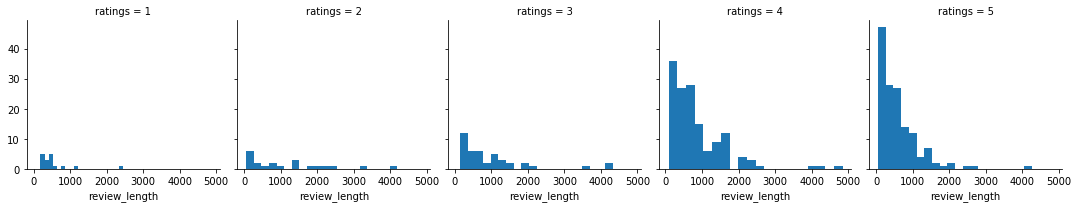

In [20]:
# visualize the review length of each rating
length = sns.FacetGrid(data=df, col='ratings')
length.map(plt.hist, 'review_length', bins=20)

### Word Cloud

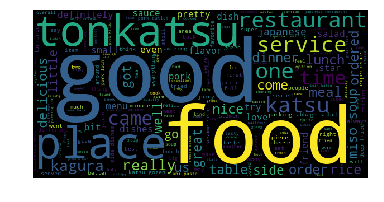

In [21]:
# create a word cloud
text = ''
for review in df['reviews']:
    text = text + review
    
text = text.lower()
wordcloud = WordCloud(width=600, height=300).generate(text)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

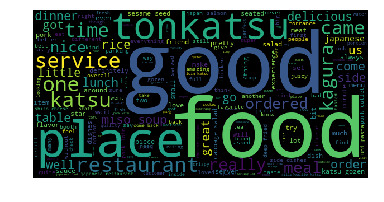

In [22]:
# create a word cloud for good ratings
text = ''
if df['ratings_info'].any() == 'good':
    for review in df['reviews']:
        text = text + review
    
text = text.lower()
wordcloud = WordCloud(width=600, height=300).generate(text)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()